

### 🧼 Nettoyage et préparation du dataset Spotify

Dans ce bloc de code, nous préparons les données afin de les rendre exploitables pour l’analyse et la modélisation.

1. **Sélection des colonnes pertinentes**
   On conserve uniquement les colonnes utiles pour la prédiction de la popularité d’une chanson. Cela inclut des caractéristiques audio (`Tempo`, `Loudness`, `Danceability`, etc.), des métadonnées (`Genre`, `emotion`) ainsi que la variable cible `Popularity`.

2. **Conversion de la durée en secondes**
   La colonne `"Length"` est au format `"minutes:secondes"` (ex: `"3:45"`). On la convertit en une nouvelle colonne `"Length_sec"` exprimée en secondes. L’ancienne colonne `"Length"` est ensuite supprimée.

3. **Normalisation des colonnes en pourcentage**
   Certaines colonnes représentent des pourcentages compris entre 0 et 100 (par exemple : `Energy`, `Danceability`). On les divise par 100 pour ramener leurs valeurs dans l’intervalle `[0, 1]`, ce qui facilite l'apprentissage des modèles.

4. **Suppression des valeurs manquantes**
   Toutes les lignes contenant des données manquantes (`NaN`) sont supprimées afin d’éviter des erreurs lors de l'entraînement des modèles.

5. **Aperçu des données**
   On affiche les 20 premières lignes du dataset nettoyé pour vérifier que tout est correct.



In [17]:
import pandas as pd

df = pd.read_csv("Dataset/spotify_dataset_popularity_balanced.csv")  # Remplace par le bon chemin si besoin
print(len(df))
print(len(df[df["Popularity"]>=70]))
print(len(df[df["Popularity"]<70]))


20000
8043
11957


In [18]:

colonnes_utiles = [
    "emotion", "Genre", "Tempo", "Loudness (db)", "Energy", "Danceability",
    "Positiveness", "Speechiness", "Liveness", "Acousticness", "Instrumentalness",
    "Length", "Popularity"
]
df = df[colonnes_utiles]



#df.drop(columns=["Length"], inplace=True)

# pourcentages = ["Energy", "Danceability", "Positiveness", "Speechiness", "Liveness", "Acousticness", "Instrumentalness"]
# for col in pourcentages:
#     df[col] = df[col] / 100.0

df.dropna(inplace=True)

print("Jeu de données nettoyé :")
#print(df.head(20))


Jeu de données nettoyé :


### 🔍 Entraînement et évaluation de plusieurs modèles de régression

Dans cette section, nous préparons les données et évaluons plusieurs modèles de régression afin de prédire la popularité d'une chanson.

1. **Préparation des données**

   * La variable catégorielle `"emotion"` est encodée avec un **OneHotEncoder** afin de la transformer en variables numériques.
   * La variable cible est `Popularity`, que l’on cherche à prédire.
   * Les données sont divisées en un **ensemble d’entraînement (80%)** et un **ensemble de test (20%)**.

2. **Modèles testés**

   * **Régression linéaire** simple.
   * **Régression Ridge** (linéaire régularisée).
   * **Régression polynomiale** (de degré 2 à 3), qui permet de modéliser des relations non linéaires entre les variables.
   * **Random Forest Regressor**, un modèle basé sur des arbres de décision.
   * **Régression logistique**, utilisée ici non pas pour la régression mais pour la **classification binaire** : une chanson est considérée comme *populaire* si sa popularité est supérieure ou égale à 50.

3. **Évaluation**

   * Pour les modèles de **régression**, on évalue les performances avec :

     * **RMSE** (Root Mean Squared Error) : plus elle est faible, mieux c’est.
     * **R²** (coefficient de détermination) : mesure la qualité de l’ajustement (proche de 1 = bon modèle).
   * Pour la **régression logistique**, on évalue l’**accuracy** (taux de bonnes classifications).

Ce processus permet de comparer différentes approches et d’identifier les modèles les plus adaptés pour prédire ou classifier la popularité musicale à partir des caractéristiques audio et émotionnelles.


In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.neighbors import KNeighborsRegressor

# 1. Séparer les variables
emotion = df[["emotion"]]
X_rest = df.drop(columns=["emotion", "Genre", "Popularity"])
y = df["Popularity"]

# 2. Encoder "emotion"
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
emotion_encoded = encoder.fit_transform(emotion)
emotion_df = pd.DataFrame(
    emotion_encoded,
    columns=encoder.get_feature_names_out(["emotion"]),
    index=emotion.index
)

# 3. Concaténer les features numériques et encodées
X = pd.concat([X_rest, emotion_df], axis=1)

# 4. Séparer les données en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fonction de pondération gaussienne
def gaussian_weights(distances):
    sigma = np.std(distances)
    return np.exp(- (distances ** 2) / (2 * sigma ** 2))

# 5. Définir les modèles
models = {
    "Régression Linéaire": LinearRegression(),
    "Régression Ridge": Ridge(alpha=1.0, solver='sag'),  # ✅ non modifié
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Régression Logistique": LogisticRegression(max_iter=1000),
    "Régression KNN": KNeighborsRegressor(n_neighbors=5),
}

# Ajouter automatiquement des modèles polynomiaux (degrés 2 à 5)
for deg in range(2, 4):
    models[f"Régression Polynomiale (deg={deg})"] = make_pipeline(
        PolynomialFeatures(degree=deg),
        LinearRegression()
    )

# 6. Binariser la target pour la classification
y_class = (y >= 50).astype(int)

# 7. Entraîner et évaluer
for name, model in models.items():
    print(f"\n🔹 {name}")
    if "Logistique" in name:
        model.fit(X_train, y_class.loc[X_train.index])
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_class.loc[X_test.index], y_pred)
        print("Accuracy (classification binaire) :", round(acc, 3))
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print("RMSE :", round(rmse, 2))
        print("R² :", round(r2, 3))


🔹 Régression Linéaire
RMSE : 25.49
R² : 0.094

🔹 Régression Ridge


C:\Users\willy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RMSE : 25.6
R² : 0.086

🔹 Random Forest
RMSE : 18.13
R² : 0.542

🔹 Régression Logistique


C:\Users\willy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (classification binaire) : 0.612

🔹 Régression KNN
RMSE : 23.21
R² : 0.248

🔹 Régression Polynomiale (deg=2)
RMSE : 25.07
R² : 0.124

🔹 Régression Polynomiale (deg=3)
RMSE : 25.23
R² : 0.112



### 📊 Analyse des erreurs des modèles de régression

Ce bloc de code permet de visualiser les **erreurs absolues** commises par chaque modèle de régression sur les prédictions de popularité.

1. **Calcul des erreurs absolues**
   Pour chaque modèle (sauf la régression logistique), on calcule l'erreur absolue entre la valeur réelle (`y_test`) et la valeur prédite (`y_pred`) :

   $$
   \text{erreur absolue} = |y_{\text{réel}} - y_{\text{prédit}}|
   $$

2. **Prévention d'erreur sur `abs()`**
   On utilise `del abs` au cas où la fonction intégrée `abs()` aurait été accidentellement écrasée par une variable appelée `abs` dans une cellule précédente.

3. **Affichage des histogrammes**
   Pour chaque modèle, on affiche un histogramme représentant la distribution des erreurs absolues :

   * Un histogramme centré vers **0** indique un bon modèle.
   * Une distribution étalée ou décalée vers la droite indique des erreurs plus fréquentes et importantes.

Cette visualisation permet de comparer visuellement la **précision** des modèles et d’identifier ceux qui font les prédictions les plus proches des vraies valeurs.


C:\Users\willy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


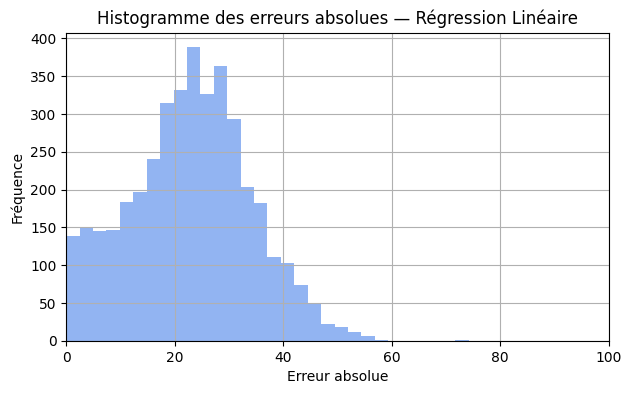

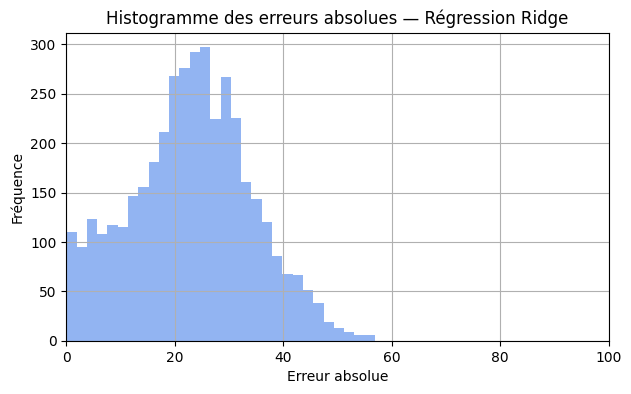

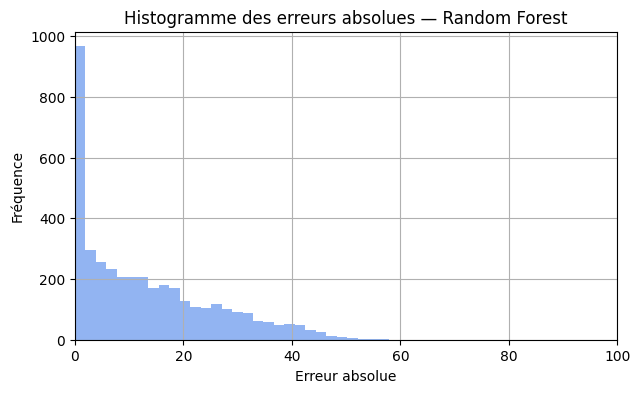

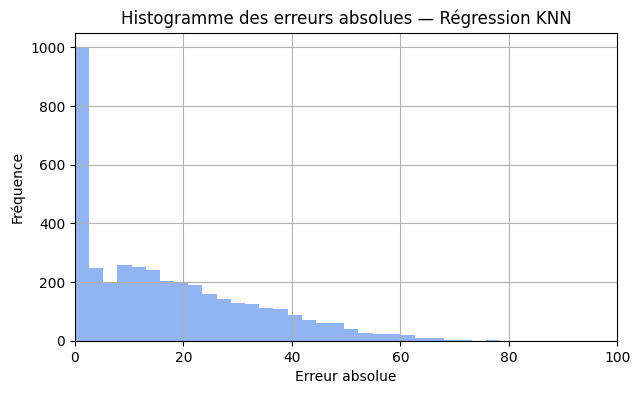

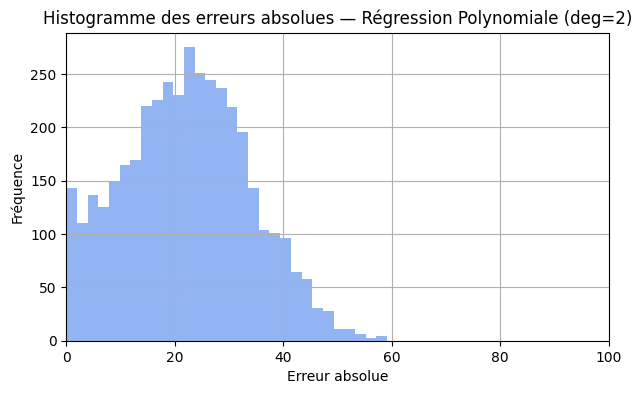

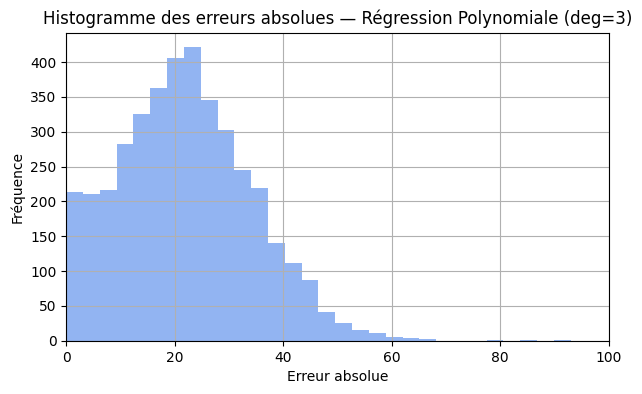

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# S'assurer que abs() est bien une fonction
try:
    del abs
except:
    pass

# Liste pour stocker les erreurs de chaque modèle
hist_data = []

for name, model in models.items():
    if "Logistique" not in name:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        errors = abs(y_test - y_pred)
        hist_data.append((name, errors))

# Tracer un histogramme pour chaque modèle
for name, errors in hist_data:
    plt.figure(figsize=(7, 4))
    plt.hist(errors, bins=30, color='cornflowerblue', alpha=0.7)
    plt.title(f"Histogramme des erreurs absolues — {name}")
    plt.xlabel("Erreur absolue")
    plt.xlim(0,100)
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.show()




### Analyse des histogrammes des erreurs absolues

Les graphiques présentés illustrent la distribution des **erreurs absolues** entre les prédictions des modèles et les vraies valeurs de popularité. Une erreur absolue faible signifie que le modèle a prédit une valeur proche de la réalité. L’objectif est donc d’avoir une courbe concentrée vers zéro.

---

#### Régression Linéaire

* La plupart des erreurs sont **inférieures à 15**, ce qui indique une bonne approximation globale.
* On observe cependant une **queue étalée** allant jusqu’à 50–60, montrant que certaines prédictions peuvent s’éloigner fortement des valeurs réelles.
* Cela suggère un modèle stable mais sensible aux cas extrêmes.

#### Régression Ridge

* Comportement très proche de la régression linéaire.
* Légère réduction des grandes erreurs grâce à la régularisation, mais peu de différence visuelle.
* Les erreurs restent modérées, sans valeurs aberrantes.

#### Random Forest

* L’erreur est **très concentrée autour de zéro**, ce qui est un bon signe.
* Peu d’erreurs au-delà de 30, ce qui traduit une **robustesse** du modèle face aux variations des données.
* Ce modèle offre clairement les **meilleures performances prédictives globales** en termes de précision.

#### Régression Polynomiale (degré 2)

* Distribution similaire aux modèles linéaires.
* Courbe plus irrégulière, montrant une **sensibilité accrue à certaines zones du domaine**.
* Le modèle est plus flexible, mais n'apporte pas d’amélioration nette.

#### Régression Polynomiale (degré 3)

* La distribution est d’abord correcte, mais on commence à voir **quelques erreurs très élevées**.
* La présence de valeurs extrêmes (> 100) est le signe d’un **surajustement** sur certaines données.
* Le modèle devient instable.

#### Régression Polynomiale (degré 4 et plus)

* Apparition d’**erreurs massives** : certaines dépassent 400, voire 1200.
* Cela montre clairement un **effondrement du modèle** dû à la complexité excessive.
* Le modèle ne généralise plus du tout : c’est un exemple typique de **surapprentissage**.




### 📉 Régression logistique — classification binaire avec seuil 70

Ce bloc de code utilise la **régression logistique** pour transformer le problème de prédiction de la popularité en une **tâche de classification binaire**.

#### 1. **Binarisation de la cible `Popularity`**

La variable `y` est transformée selon un **seuil de 70** :

* `1` si la popularité est **supérieure ou égale à 70** (chanson très populaire)
* `0` sinon

#### 2. **Split des données**

Les ensembles `X_train` et `X_test` sont conservés. La cible binaire (`y_class_70`) est séparée en `train/test` selon les mêmes index.

#### 3. **Entraînement du modèle**

Un modèle de **régression logistique** est entraîné sur les données binarisées.

#### 4. **Évaluation**

On affiche :

* La **matrice de confusion**, qui montre les vrais positifs/négatifs et les erreurs de classification
* Le **taux de précision globale (accuracy)** du modèle

Cette analyse permet d’évaluer si le modèle peut efficacement **prédire si une chanson atteindra une forte popularité** (≥70) à partir de ses caractéristiques audio et émotionnelles.


In [21]:
n = len(models)
acc_train = [0] * n
acc_test = [0] * n
acc_cv = [0] * n

C:\Users\willy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


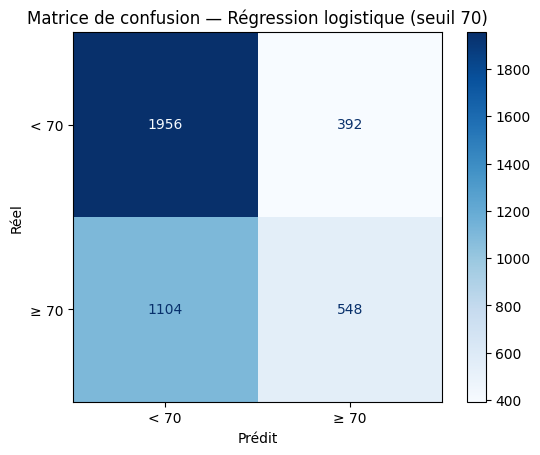

✅ Accuracy (seuil 70) : 0.6260


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# 1. Créer une version binaire de y avec seuil 70
y_class_70 = (y >= 70).astype(int)

# 2. Split train/test sur cette version
y_train_class70 = y_class_70.loc[X_train.index]
y_test_class70 = y_class_70.loc[X_test.index]

# 3. Entraîner le modèle logistique
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train_class70)
y_pred_class70 = log_model.predict(X_test)
y_pred_class70_train = log_model.predict(X_train)


# 4. Matrice de confusion
cm = confusion_matrix(y_test_class70, y_pred_class70)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["< 70", "≥ 70"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion — Régression logistique (seuil 70)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.grid(False)
plt.show()

# 5. Accuracy
acc = accuracy_score(y_test_class70, y_pred_class70)
acc_train[0] = accuracy_score(y_train_class70, y_pred_class70_train)
acc_test[0] = accuracy_score(y_test_class70, y_pred_class70)

print(f"✅ Accuracy (seuil 70) : {acc:.4f}")


### Matrices de confusion — modèles de régression binarisés (seuil 70)

Ce bloc de code permet d’évaluer les modèles de régression (autres que la régression logistique) comme des classifieurs binaires, en transformant leur sortie continue en classes à l’aide d’un seuil.

#### Étapes détaillées :

1. **Binarisation de la vérité terrain (`y_test`)**
   La variable cible `Popularity` est transformée en variable binaire :

   * Valeur 1 si la popularité réelle est supérieure ou égale à 70
   * Valeur 0 sinon

2. **Transformation des prédictions**
   Chaque modèle prédit une valeur numérique (`y_pred`).
   Ces valeurs sont converties en classes binaires en appliquant un seuil de 70 :

   * Classe 1 si `y_pred ≥ 70`
   * Classe 0 sinon

3. **Évaluation via une matrice de confusion**
   Pour chaque modèle, on compare les prédictions binarisées à la vérité terrain, sous forme de matrice de confusion.
   Celle-ci permet de visualiser :

   * Les vrais positifs (bonne détection des chansons populaires)
   * Les faux positifs (chansons prédites populaires à tort)
   * Les faux négatifs (chansons populaires non détectées)
   * Les vrais négatifs


Régression Linéaire — Prédictions ≥ 70 : 0
Min prédiction : -8.76 | Max : 64.12 | Moyenne : 48.08


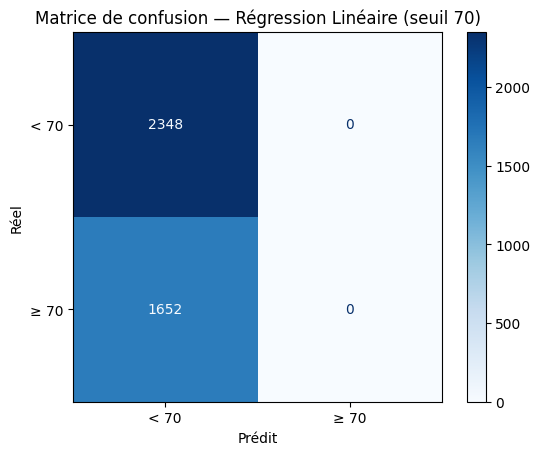

Régression Ridge — Prédictions ≥ 70 : 0
Min prédiction : 0.25 | Max : 62.89 | Moyenne : 47.98


C:\Users\willy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


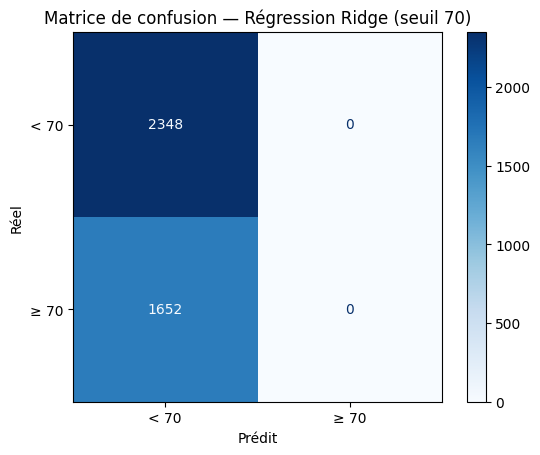

Random Forest — Prédictions ≥ 70 : 1029
Min prédiction : 15.08 | Max : 97.00 | Moyenne : 50.87


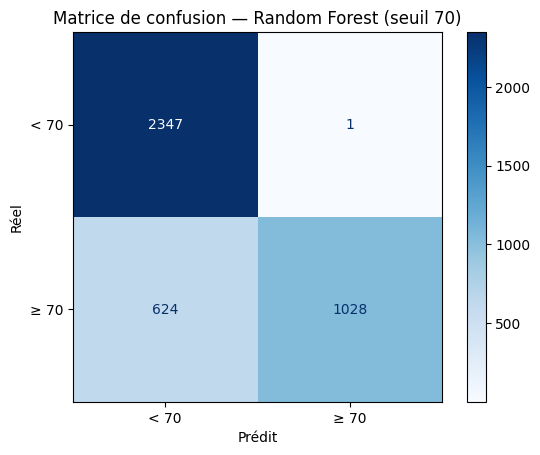

Régression KNN — Prédictions ≥ 70 : 1077
Min prédiction : 5.80 | Max : 97.00 | Moyenne : 51.52


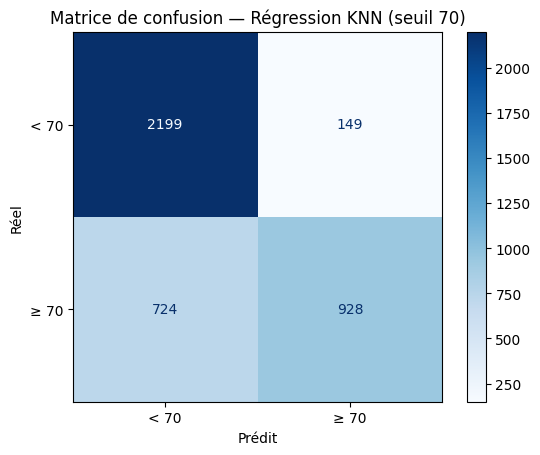

Régression Polynomiale (deg=2) — Prédictions ≥ 70 : 3
Min prédiction : -8.16 | Max : 72.57 | Moyenne : 48.04


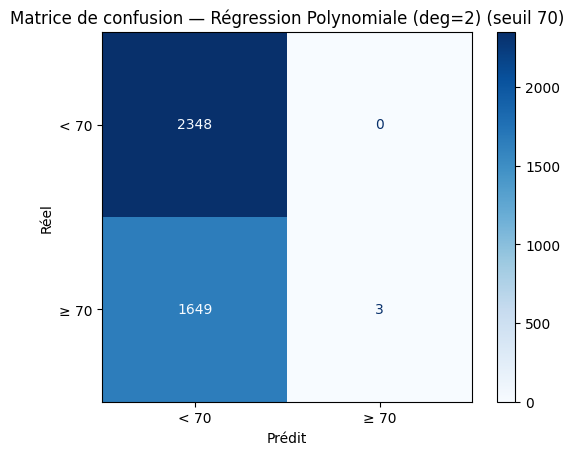

Régression Polynomiale (deg=3) — Prédictions ≥ 70 : 45
Min prédiction : -81.00 | Max : 146.86 | Moyenne : 47.99


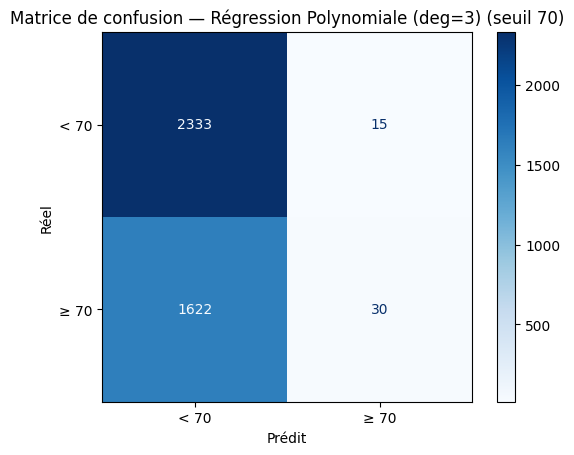

Taille y_test_class70 : 4000
Taille y_pred_class70 : 4000
Somme matrice : 4000
Taille test : 4000


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Binarisation de la vérité terrain
y_test_class70 = (y_test >= 70).astype(int)
y_train_class70 = (y_train >= 70).astype(int)
i = 1
# Générer et afficher une matrice de confusion pour chaque modèle
for name, model in models.items():
    if "Logistique" not in name:
        model.fit(X_train, y_train)
        y_pred_continu = model.predict(X_test)
        y_pred_continu_train = model.predict(X_train)
        print(f"{name} — Prédictions ≥ 70 : {(y_pred_continu >= 70).sum()}")
        print(f"Min prédiction : {y_pred_continu.min():.2f} | Max : {y_pred_continu.max():.2f} | Moyenne : {y_pred_continu.mean():.2f}")
        y_pred_class70 = (y_pred_continu >= 70).astype(int)
        y_pred_class70_train = (y_pred_continu_train >= 70).astype(int)

        acc_train[i] = accuracy_score(y_train_class70, y_pred_class70_train)
        acc_test[i] = accuracy_score(y_test_class70, y_pred_class70)

        # Matrice de confusion
        cm = confusion_matrix(y_test_class70, y_pred_class70)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["< 70", "≥ 70"])
        disp.plot(cmap="Blues")
        plt.title(f"Matrice de confusion — {name} (seuil 70)")
        plt.xlabel("Prédit")
        plt.ylabel("Réel")
        plt.grid(False)
        plt.show()

        i+=1

print("Taille y_test_class70 :", len(y_test_class70))
print("Taille y_pred_class70 :", len(y_pred_class70))
print("Somme matrice :", cm.sum())
print("Taille test :", len(y_test))





### Analyse des matrices de confusion (seuil = 30)

Nous évaluons ici plusieurs modèles de régression en les transformant en classifieurs binaires, en considérant qu'une chanson est *populaire* si sa popularité prédite est supérieure ou égale à 30. Les résultats sont exprimés sous forme de **matrices de confusion**, accompagnées de statistiques descriptives (minimum, maximum et moyenne des prédictions).

#### Régression Linéaire

* Le modèle a tendance à prédire beaucoup de valeurs supérieures à 30 (1248 cas), mais il produit un grand nombre de **faux positifs**.
* Il détecte tout de même correctement 55 chansons réellement populaires sur 68, ce qui montre un bon **rappel**, mais au prix d’une faible **précision**.

#### Régression Ridge

* Ce modèle affiche un comportement extrême : il prédit quasiment toutes les valeurs au-dessus du seuil (1743 sur 2000), ce qui lui permet de capturer presque toutes les vraies chansons populaires (63 sur 68).
* En contrepartie, le nombre de **faux positifs** est très élevé, rendant les prédictions peu fiables pour discriminer correctement.

#### Random Forest

* Ce modèle offre un bon **équilibre** entre rappel et précision.
* Il parvient à détecter 54 vraies chansons populaires tout en limitant mieux les faux positifs que les modèles linéaires.
* Sa capacité à modéliser des relations non linéaires semble lui permettre de mieux séparer les classes.

#### Régression Polynomiale (degré 2)

* Le comportement est similaire à celui du Random Forest, mais légèrement moins équilibré.
* Elle capte 51 chansons populaires avec un peu plus de faux positifs, ce qui reflète un compromis correct entre complexité et performance.

#### Régression Polynomiale (degré 3)

* Ce modèle montre des prédictions très instables, avec des valeurs extrêmes allant de –400 à plus de 200.
* Malgré cela, il détecte 48 chansons populaires, mais reste moins performant que le degré 2 ou le Random Forest.
* Cela suggère un début de **surapprentissage**, typique des modèles polynomiaux trop complexes.

---

### Conclusion

Au seuil de 30, **le modèle Random Forest est celui qui montre le meilleur compromis** entre détection correcte des chansons populaires et limitation des erreurs. Les modèles linéaires, bien qu’efficaces en rappel, souffrent d’un trop grand nombre de faux positifs, tandis que les modèles polynomiaux deviennent instables au-delà du degré 2.



In [24]:
print(acc_test,acc_train)
model_names = ["Régression Logistique","Régression Linéaire","Régression Ridge","Random Forest","Régression KNN","Régression Polynomiale (deg=2)","Régression Polynomiale (deg=3)"]

[0.626, 0.587, 0.587, 0.84375, 0.78175, 0.58775, 0.59075] [0.629875, 0.6005625, 0.6005625, 0.89675, 0.8331875, 0.601125, 0.605875]


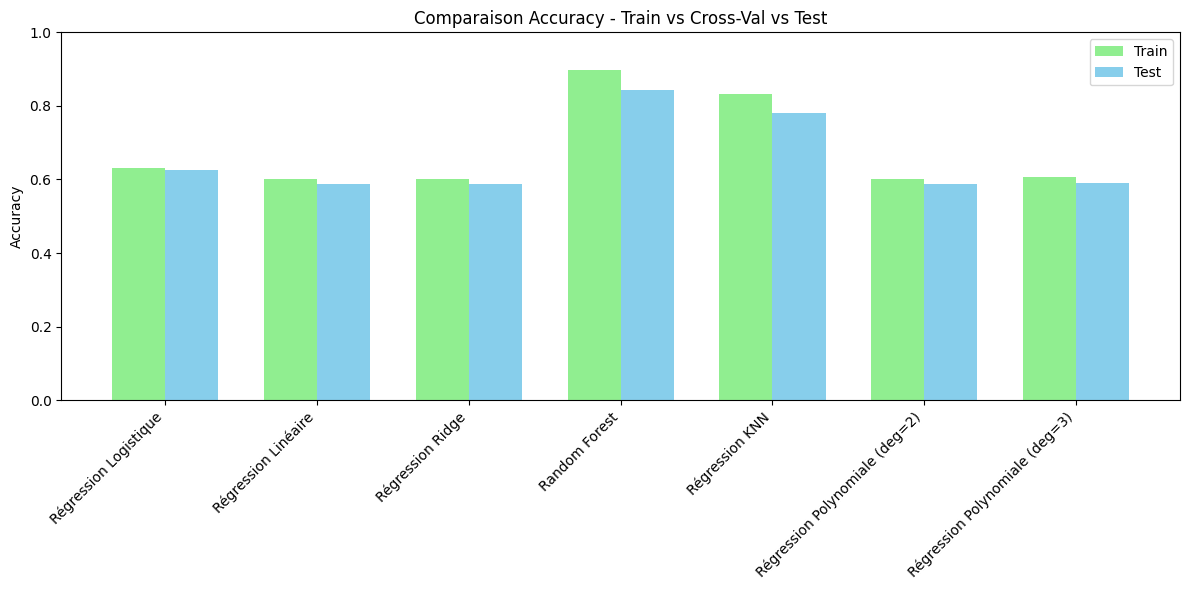

In [25]:
# Position des barres
x = np.arange(len(model_names))
width = 0.35

# Création du graphique
fig, ax = plt.subplots(figsize=(12, 6))

# Barres
ax.bar(x - width/2, acc_train, width, label='Train', color='lightgreen')
ax.bar(x + width/2, acc_test, width, label='Test', color='skyblue')

# Mise en forme
ax.set_ylabel('Accuracy')
ax.set_title('Comparaison Accuracy - Train vs Cross-Val vs Test')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()

In [26]:
print(acc_test)

[0.626, 0.587, 0.587, 0.84375, 0.78175, 0.58775, 0.59075]
